# Image Style Transfer

You will need the following package to run this notebook:

`keras_contrib` - install with:

`pip install git+https://www.github.com/keras-team/keras-contrib.git`

## Introduction
A recent development in applications of deep nerual networks is the concept of style transfer. This is form of image modification by which a network takes a content image and applies the style of another image to it. The original implementation of neural style transfer was done by Leon Gatys et al. in 2015.

The main idea behind style transfer is to maintain the structure of the content image while applying the texture of the style image. Here, the content of an image refers to the larger structures in the image, say the dog or fencing in the following picture:
<img src="./images/newton.jpg">

When we refer to style, we are refering to the colors, lines, and shapes that occur across an entire image. An example is the waves in the following picture:
<img src="./images/wave_style.png" height="256" width="350">

The result of applying the waves style to the picture of the dog is show here:
<img src="./images/newton_wave.jpg">

## The Loss Function
Similar to any other neural network, we define a loss function and work to minimize that loss. If we have functions `style` and `content` that can mathematicaly represent the style and content of an image respectfully, we can define our loss function as follows:

`loss = distance(style(style image) - style(generated image)) + 
       distance(content(content image) - content(generated image))`

(Chollet, https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.3-neural-style-transfer.ipynb)

While defining a function that mathematically represents the content or style of an image does not seem trivial, what Gatys et al. were able to show was that deep neural networks could be used to represent the content and style of images mathematically.

### Content Loss
As discussed in the CNN Visualization lecture, the activations of lower levels of a CNN react to small details and features, while the upper layers tend to represent higher level structures within the image. Therefore, the upper levels of an image are more suitable for representing image content.

If we wish to determine the content loss, we can then compare the activations of the upper layers of our network when we feed it the content and generated image. A good option for this is the L2 norm, which was used by Gatys et al. in their original implementation.

$$ \ell^{\phi, j}_{feat}(\hat{y}, y) = \frac{1}{C_jH_jW_J} \lVert \phi_j(\hat{y}) - \phi_j(y) \rVert^2_2 $$

### Style Loss
Stlye loss is more complicated. If we want to represent the style of an image, it would not serve us well to only consider they style at one scale. Instead, we want to consider the image at multiple scales so that large and small features of the content image all recieve style transformation. To do this, Gatys et al. used the Gram matrix of a layer's activations. The Gram matrix captures the correlations between features of a given layer, which in turn capture pattern statistics at a given scale.

To do that, we can extract the features at the various ReLU layers of VGG16.
<img src="./images/transform_net.png">
(Johnson et al., Perceptual losses for real-time style transfer and super-resolution)

The style loss is then defined as the squared Frobenius norm of the difference between the Gram matrices of the output and target images:

$$ \ell^{\phi, j}_{style}(\hat{y}, y) = \lVert G^{\phi}_j(\hat{y}) - G^{\phi}_j(\hat{y}) \rVert^2_F $$

The Gram matrix can be computed efficiently by:

$$ G^{\phi}_j(x) = \psi\psi^T / C_jH_jW_j $$

where $\psi$ is $\phi_j(x)$ reshaped with shape $ C_j \times H_jW_j $.

With multiple style layers, we take the sum of losses for each layer.

## Style Transfer Example
Here we will use VGG to transfer the style of the wave image above onto the image of the dog.

In [1]:
from keras.layers import Conv2D, Conv2DTranspose, Input, Lambda, Activation
from keras.models import Model
import keras.layers
from keras.initializers import TruncatedNormal

from keras_contrib.layers.normalization import InstanceNormalization

WEIGHTS_INIT_STDEV = .1

def Conv2DInstanceNorm(inputs, filters, kernel_size,
                           strides=1, relu=True):
    weights_init = TruncatedNormal(stddev=WEIGHTS_INIT_STDEV, seed=1)
    conv = Conv2D(filters,
                  (kernel_size, kernel_size),
                  strides=strides,
                  padding='same',
                  kernel_initializer=weights_init,
                  use_bias=False)(inputs)
    norm = InstanceNormalization(axis=3)(conv)
    if relu:
        norm = Activation('relu')(norm)
    return norm

def Conv2DTransposeInstanceNorm(inputs, filters, kernel_size,
                                strides=1, relu=True):
    weights_init = TruncatedNormal(stddev=WEIGHTS_INIT_STDEV, seed=1)
    conv = Conv2DTranspose(filters,
                           (kernel_size, kernel_size),
                           strides=strides,
                           padding='same',
                           kernel_initializer=weights_init,
                           use_bias=False)(inputs)
    norm = InstanceNormalization(axis=3)(conv)
    if relu:
        norm = Activation('relu')(norm)
    return norm

def Conv2DResidualBlock(inputs):
    tmp     = Conv2DInstanceNorm(inputs, 128, 3)
    tmp2    = Conv2DInstanceNorm(tmp, 128, 3, relu=False)
    return keras.layers.add([inputs, tmp2])

def TransformNet(inputs):
    conv1   = Conv2DInstanceNorm(inputs, 32, 9)
    conv2   = Conv2DInstanceNorm(conv1, 64, 3, strides=2)
    conv3   = Conv2DInstanceNorm(conv2, 128, 3, strides=2)
    resid1  = Conv2DResidualBlock(conv3)
    resid2  = Conv2DResidualBlock(resid1)
    resid3  = Conv2DResidualBlock(resid2)
    resid4  = Conv2DResidualBlock(resid3)
    resid5  = Conv2DResidualBlock(resid4)
    conv_t1 = Conv2DTransposeInstanceNorm(resid5, 64, 3, strides=2)
    conv_t2 = Conv2DTransposeInstanceNorm(conv_t1, 32, 3, strides=2)
    conv_t3 = Conv2DInstanceNorm(conv_t2, 3, 9, relu=False)
    tanh = Activation('tanh')(conv_t3)
    preds = Lambda(lambda x : x * 150 + 255./2)(tanh)
    return preds

Using TensorFlow backend.


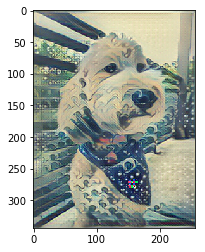

In [5]:
from keras.layers import Input
from keras.models import Model
from keras.preprocessing import image
import numpy as np
from scipy.misc import imsave
import matplotlib.pyplot as plt

# Get input image
input_img = image.load_img('./images/newton.jpg')
input_img = image.img_to_array(input_img)
input_img = np.expand_dims(input_img, axis=0)


# Load model
_, h, w, c = input_img.shape
inputs = Input(shape=(h, w, c))
transform_net = TransformNet(inputs)
model = Model(inputs, transform_net)
model.load_weights('./models/wave.h5')

output_img = model.predict([input_img])[0]
plt.imshow(output_img/255)
plt.show()

## Universal Style Transfer
The models above are trained to work for a single style. Using these methods, in order to create a new style transfer model, you have to train the model with a wide variety of content images.

Recent work by Yijun Li et al. shows that it is possible to create a model that generalizes to unseen style images, while maintaining the quality of output images.

Their method works by treating style transfer as an image reconstruction task. They use a VGG19 ReLU layer to encode features of various content images and traing a decoder to reconstruct these images. Then, with these two networks fixed, they feed the content and the style image into the encoder and use a whitening and coloring transform so that the covarience matrix of the features matches the covarience matrix of the style.

This process can then be expanded to the remaining ReLU layers of VGG19 to create a style transfer network that can apply to all spatial scales.

Since only content images were used to train the encoder and decoder, additional training is not needed when generalizing this to new styles.

Here, we will walk though an example model for universal style transfer, which accepts any style and content image.

## References
Neural Style Transfer reference notebook, Francois Chollet: https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.3-neural-style-transfer.ipynb

Perceptual losses for real-time style transfer and super-resolution, Justin Johnson et al.:
https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf

A Neural Algorithm of Artistic Style, Leon Gatys et al.: https://arxiv.org/pdf/1508.06576.pdf

Universal Style Transfer, Yijun Li et al.: https://arxiv.org/pdf/1705.08086.pdf